In [31]:
from basepolygon_class import GoalPolygon
from shapely.geometry import Polygon, LineString
place_one = GoalPolygon('Жилой комплекс "Жулебино Парк" стройка')
v = place_one.polygon

/opt/anaconda3/envs/tests/lib/python3.10/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))
/opt/anaconda3/envs/tests/lib/python3.10/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))
/opt/anaconda3/envs/tests/lib/python3.10/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


Геометрическое упрощение

In [2]:
def get_xy(s):

    x, y = s.centroid.coords.xy
    return x[0], y[0]

Здесь полигон в нуле не от центра

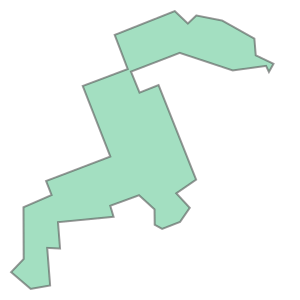

In [8]:
from shapely.affinity import translate
import numpy as np

s = v.simplify(10, preserve_topology=True)
x, y, _, _ = v.bounds
#x, y = get_xy(s)
st = translate(s, 0-x, 0-y)
st

In [4]:
coor_list = (list(st.boundary.coords[0:len(st.boundary.coords) - 1]))

разбиение точек на группы по сегментам

In [32]:
from itertools import islice, cycle

def vec_search(point_list, key):
    cr = []
    n = list(islice(cycle(range(len(point_list))), 0, len(point_list) *2))
    for i in range(len(point_list)):
        v_one = [point_list[n[i]][0] - point_list[n[i + 1]][0], point_list[n[i]][1] - point_list[n[i + 1]][1], 0]
        v_two = [point_list[n[i + 1]][0] - point_list[n[i + 2]][0], point_list[n[i + 1]][1] - point_list[n[i + 2]][1],0]
        v_o_norm, v_t_norm = v_one / np.linalg.norm(v_one), v_two / np.linalg.norm(v_two)
        if np.cross(v_o_norm, v_t_norm)[2] < key:
            cr.append(n[i + 1])
        else:
            pass
    cross = [*cr, cr[0] + cr[-1] + 1]
    double_points = [*range(len(point_list)), *range(len(point_list))]
    points = [*point_list, *point_list]
    segments = [double_points[cross[c]:cross[c + 1]+1] for c in range(len(cross) - 1)]
    lines = [LineString(points[cross[c]:cross[c + 1]+1]) for c in range(len(cross) - 1)]
    return segments, lines

In [65]:
bb, ll = vec_search(coor_list, 0.5)
print(ll)

[<shapely.geometry.linestring.LineString object at 0x7f7f7538ac50>, <shapely.geometry.linestring.LineString object at 0x7f7f75388d00>, <shapely.geometry.linestring.LineString object at 0x7f7f7538ad10>, <shapely.geometry.linestring.LineString object at 0x7f7f75389d20>, <shapely.geometry.linestring.LineString object at 0x7f7f75388df0>, <shapely.geometry.linestring.LineString object at 0x7f7f7538b010>, <shapely.geometry.linestring.LineString object at 0x7f7f7538a560>, <shapely.geometry.linestring.LineString object at 0x7f7f75389540>, <shapely.geometry.linestring.LineString object at 0x7f7f7538bd00>, <shapely.geometry.linestring.LineString object at 0x7f7f7538bd30>, <shapely.geometry.linestring.LineString object at 0x7f7f7538a710>, <shapely.geometry.linestring.LineString object at 0x7f7f75388430>, <shapely.geometry.linestring.LineString object at 0x7f7f7538a1d0>, <shapely.geometry.linestring.LineString object at 0x7f7f7538a920>, <shapely.geometry.linestring.LineString object at 0x7f7f7538a

In [11]:
def chains_base (point_list, parts):
    vectors =[]
    for i in parts:
        temp =[]
        for l in range(len(i)-1):
            vec = [point_list[i[l]][0] - point_list[i[l+1]][0], point_list[i[l]][1] - point_list[i[l+1]][1]]
            temp.append(vec)
        vectors.append(temp)
    return vectors

In [36]:
res_vec = chains_base(coor_list, bb)

SVD

In [15]:
from scipy.linalg import svd
import numpy as np
import torch

A = np.asarray(res_vec)

/var/folders/l7/52t7xngd2973k8x9_y55rmyh0000gn/T/ipykernel_21055/2655982256.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  A = np.asarray(res_vec)


In [16]:
class SvdItem:
    keys=["A", "U", "S", "Vh", "Sigma"]
    def __init__(self, m, collection=None, **kwargs):
        self.A = torch.tensor(m)
        self.collection=collection
        self.U = None
        self.S = None
        self.Vh = None
        self.Sigma = None
        self.svd(**kwargs)
        if collection is not None:
            self.id = f'{collection.id}:{len(collection.matrices)}'
            print(f'set item id: {self.id}')
            collection.A.append(self.A)



    def svd(self, **kwargs):
        U, S, Vh = torch.linalg.svd(self.A, **kwargs)
        Sigma = torch.diag(S)
        self.U, self.S, self.Vh, self.Sigma=U, S, Vh, Sigma
        print(self.U, self.S, self.Vh, self.Sigma)
        if self.collection:
            for v, k in zip([A, U, S, Vh, Sigma], self.__class__.keys):
                (self.collection.__dict__[k]).append(v)

        return U, S, Vh, Sigma
    def pack(self):
        self.collection.__dict__[self.__class__.__name__][self.collection.id]|={self.id:self}
        return self.id, self



class SvdPack:
    def __init__(self):
        self._matrices = []
        self.id = f'{0}:{0}'
        self.A, self.U, self.S, self.Vh, self.Sigma = [], [], [], [], []
        self.tree= {self.id:{}}



    @property
    def matrices(self):
        return self._matrices
    @matrices.setter
    def matrices(self, val, **kwargs):
        if len(val.shape) == 2:
            self._matrices.append(SvdItem(val, collection=self, **kwargs))
        else:
            for v in val:
                self._matrices.append(SvdItem(v, collection=self, **kwargs))

In [17]:
pck = SvdPack()

In [ ]:
a_=np.asarray(res_vec, dtype=object)
pck.matrices = a_

In [ ]:
pck_vh = pck.Vh

Работа с транспортированными точками

In [ ]:
def matricies_check(matricies_list):
    matrix_checked = []
    for i in matricies_list:
        if i[0][1]<0 and i[1][0]>0 or i[0][1]>0 and i[1][0]<0 :
            matrix_checked.append(i)
        else:
            #ii = np.fliplr(i)*(-1)
            i[1]*= -1
            matrix_checked.append(i)
    return matrix_checked

identical_matricies = matricies_check(pck_vh)
identical_matricies

In [21]:
def transform_chains_from_vh(chains, t):
    chains_t=[]
    for i, clust in enumerate(chains):
        _t=[]
        for j in clust:
            _ = t[i] @ np.asarray(coor_list[j])
            _t.append(np.asarray(_).tolist())
        chains_t.append(_t)
    return chains_t

p_t = transform_chains_from_vh(bb, identical_matricies)

In [23]:
def chains_ (point_list):
    vectors =[]
    for i in point_list:
        temp =[]
        for l in range(len(i)-1):
            vec = [i[l][0] - i[l+1][0], i[l][1] - i[l+1][1]]
            temp.append(vec)
        vectors.append(temp)
    return vectors

v_t = chains_(p_t)
# not transformed vec
v_ = res_vec

In [26]:
def unit_vector(vector):
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

def angle (v_tr, v_b):
    ang =[]
    for j, i in enumerate(v_tr):
        for ind, val in enumerate(i):
            ang.append(angle_between(val, v_b[j][ind]))
            break
    return ang

angl = angle(v_t, res_vec)

In [ ]:

scope = np.asarray(angl)/np.linalg.norm(angl)
r = np.round(scope*len(angl),0)
labels=[]
l = np.unique(r).tolist()
for i in r:
    labels.append(l.index(i))
print(labels)


Display

In [63]:
def get_clusters(data, label):
    """
    :param data: The dataset
    :param label: The label for each point in the dataset
    :return: List[np.ndarray]: A list of arrays where the elements of each array
    are data points belonging to the label at that ind
    """
    return [data[np.where(label == i)] for i in range(np.amax(label) + 1)]

d = get_clusters(np.asarray(ll, labels)
print(d)

SyntaxError: '(' was never closed (488069346.py, line 10)

In [66]:
from collections import defaultdict

temp = defaultdict(list)

for la, l in zip(labels, ll):
    temp[delvt].append(pin)

NameError: name 'delvt' is not defined

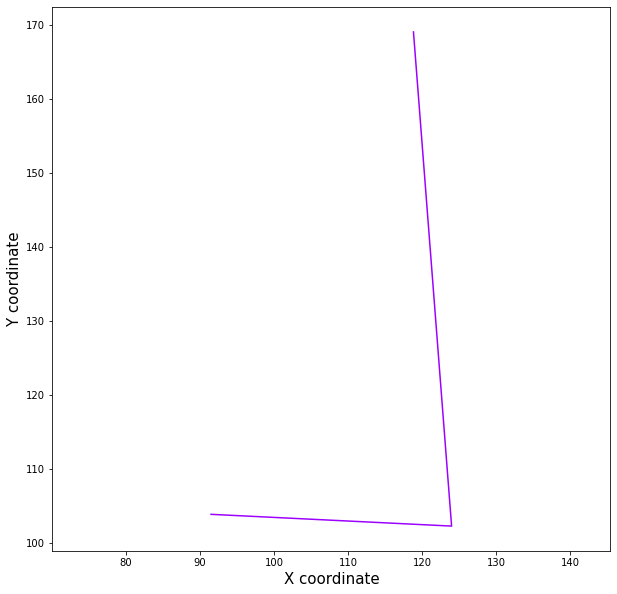

In [44]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlabel('X coordinate', fontsize=15)
ax.set_ylabel('Y coordinate', fontsize=15)


ax.plot(*ll[0].xy, label='LineString', color='#9c00ff')
ax.axis('equal')
plt.show()